In [1]:
import sys
import os
import subprocess
import pandas as pd
import numpy as np
import tempfile
import yaml

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import itertools
from scipy.stats import wilcoxon, shapiro, ttest_rel

import pickle
import os

from datetime import date
print(date.today())


2025-12-09


In [27]:
# 准备结果目录和流程所需config文件
# level 1
workdir = '/mnt/disk7t/xwj/axolotl_rev/'
datadir = '/mnt/disk7t/xwj/axolotl_rev/ly_111/'
output_path = f'{workdir}/result/dataset_ly111'


use = 'ly111'
tissues = pd.read_csv(f'{datadir}/tissues_{use}.tsv', sep='\t', index_col=0)
phase =''
outlier_sample_col = 'Sample'
outlier_gene_col = 'Gene' 

samples_path = f'{output_path}/samples'
task_config_path = f'{output_path}/task_config'
task_output_path = f'{output_path}/task_output'
metric_output_path = f'{output_path}/metric'

tissues1 = tissues.copy()
tissues1['OUTLIER_FILE'] = f'{datadir}/outlier_ly111_filtered_by_cts_444.tsv'
tissues = pd.concat([tissues, tissues1], axis=0)
tissues

,TISSUE_ID,TISSUE_NAME,N_SAMPLE,N_GENE,CTS_FILE,OUTLIER_FILE
0,B,blood,111,11310,/mnt/disk7t/xwj/axolotl_rev/ly_111//cts_B_s111...,/mnt/disk7t/xwj/axolotl_rev/ly_111//outlier_B_...
0,B,blood,111,11310,/mnt/disk7t/xwj/axolotl_rev/ly_111//cts_B_s111...,/mnt/disk7t/xwj/axolotl_rev/ly_111//outlier_ly...


In [35]:
outliers_used = pd.read_csv(outlierfile.replace('.tsv', f'{phase}.tsv'), sep='\t',index_col=0)
outliers_used

,Consequence,IMPACT,Gene,BIOTYPE,LoF,LoF_filter,LoF_flags,LoF_info,Sample
0,stop_gained,HIGH,LUZP1,protein_coding,HC,NaN,NaN,GERP_DIST:0&BP_DIST:2884&PERCENTILE:0.10708758...,AS17069
2,stop_gained&frameshift_variant&splice_region_v...,HIGH,YTHDF3,protein_coding,HC,NaN,NO_EXON_NUMBER,GERP_DIST:0&BP_DIST:1596&PERCENTILE:0.09410430...,AS17069
9,stop_gained,HIGH,ZC3H3,protein_coding,HC,NaN,NaN,GERP_DIST:0&BP_DIST:207&PERCENTILE:0.926940639...,AS17069
10,stop_gained,HIGH,TMEM97,protein_coding,HC,NaN,NaN,GERP_DIST:0&BP_DIST:331&PERCENTILE:0.374764595...,AS17069
11,stop_gained,HIGH,MTUS1,protein_coding,HC,NaN,NaN,GERP_DIST:0&BP_DIST:268&PERCENTILE:0.929451875...,AS20994
...,...,...,...,...,...,...,...,...,...
1477,stop_gained,HIGH,ZC3H3,protein_coding,HC,NaN,NaN,GERP_DIST:0&BP_DIST:207&PERCENTILE:0.926940639...,AS81857
1478,stop_gained,HIGH,LCN10,protein_coding,HC,NaN,NaN,GERP_DIST:0&BP_DIST:121&PERCENTILE:0.797678275...,AS81857
1481,stop_gained&frameshift_variant&splice_region_v...,HIGH,YTHDF3,protein_coding,HC,NaN,NO_EXON_NUMBER,GERP_DIST:0&BP_DIST:1596&PERCENTILE:0.09410430...,AS81858
1488,stop_gained,HIGH,KIF27,protein_coding,HC,NaN,NaN,GERP_DIST:0&BP_DIST:588&PERCENTILE:0.853043912...,AS81858


In [56]:
from sklearn.metrics import auc
# 遇到的问题 general.pred_outlier_auprc(df_pred, df_outlier)时NameError: name 'auc' is not defined
# 改成直接重定义
def sort_label_score_auprc(res_data, class_col, score_col, df_outlier):
    """
    计算ABEILLE方法单个打分方式的AUPRC
    参数:
        res_data: 包含预测结果的DataFrame
        score_col: 用于排序的打分列名
        df_outlier: 包含真实异常的DataFrame
    返回:
        auprc: AUPRC值
        pr_curve: 用于绘制的PR曲线点
    """
    # 按predict和score排序
    ascend = score_order[score_col]
    sorted_data = res_data.sort_values(by=[ class_col, score_col], ascending=[False, ascend])

    # 创建预测列
    sorted_data['rank'] = range(1, sorted_data.shape[0]+1)

    # 准备PR曲线数据
    pr_curve = sorted_data[['rank']].copy()
    # 标记真实的异常点
    pr_curve['label'] = 0
    pr_curve.loc[ zip(df_outlier['Sample'], df_outlier['Gene']), 'label'] = 1
    
    # 计算precision和recall
    pr_curve['precision'] = (pr_curve['label'].cumsum() / pr_curve['rank']).round(4)
    pr_curve['recall'] = (pr_curve['label'].cumsum() / pr_curve['label'].sum()).round(4)

    # 计算AUPRC
    auprc = auc(pr_curve['recall'], pr_curve['precision'])

    # 准备绘图用的曲线点
    pr_curve = pr_curve.drop_duplicates(subset=['precision', 'recall'])
    idx = [(pr_curve['recall'] - seg).abs().idxmin() for seg in recall_seg]
    
    return auprc, pr_curve.loc[idx]

## 定义函数来计算AUPRC
def pred_outlier_auprc(res_data, df_outlier):
    
    res_data.index.name = 'Gene'
    res_data.columns.name = 'Sample'
    res_data = res_data.T.melt(ignore_index=False,value_name='pred').set_index(['Gene'],append=True).reorder_levels([1, 0])
    sorted_data = res_data.sort_values(by='pred',ascending=True)
    sorted_data['rank'] = range(1, sorted_data.shape[0]+1)
    # 准备PR曲线数据
    pr_curve = sorted_data[['rank']].copy()
    pr_curve['label'] = 0
    
    for i, row in df_outlier.iterrows(): 
    #     print(i,row['Gene'],row['Sample'])
        pr_curve.loc[(row['Gene'], row['Sample']), 'label' ] = 1
    pr_curve['precision'] = (pr_curve['label'].cumsum()/pr_curve['rank']).round(4)
    pr_curve['recall'] = (pr_curve['label'].cumsum()/pr_curve['label'].sum()).round(4)

    # auprc value
    auprc = auc(pr_curve.loc[:,'recall'],pr_curve.loc[:,'precision'])
    
    # save a simple curve for plotting
    pr_curve = pr_curve.drop_duplicates(subset=['precision', 'recall'])
    # keep equally distributed points 
    idx = [ (pr_curve['recall'] - seg).abs().idxmin() for seg in recall_seg ]
    
    return auprc, pr_curve.loc[idx,]

## precision recall curve add segments for easy plotting
n_seg = 1000
recall_seg = np.linspace(0, 1,num=n_seg+1)

In [61]:
# 定义排序逻辑
score_order = {
    'anomaly_score': False,
    'delta_count': True,
    'divergence_score': True,
    'pValue': True,
    'padjust': True,
    'zScore': True,
}
abl_scores = ['anomaly_score', 'delta_count', 'divergence_score']
outrider_scores = [ 'padjust']

baselines = [ 'ABEILLE', 'OUTRIDER', 'OUTSINGLE',]
abl_scores = ['anomaly_score', 'delta_count', 'divergence_score']
outrider_scores = [ 'padjust']
baselines = [ f'{m}_{score}' for m in [ 'ABEILLE', 'OUTRIDER'] for score in (outrider_scores if m=='OUTRIDER' else abl_scores) ] + ['OUTSINGLE']

mymethods = [ f'{f}{m}' for f in ['f0.1', ] 
             for m in ['L20',] ]
methods = mymethods + baselines

draw_methods = [
    'f0.1L20',
    'ABEILLE/anomaly_score', 
    'ABEILLE/delta_count', 
    'ABEILLE/divergence_score', 
    'OUTRIDER/padjust', 
    'OUTSINGLE'
    ]
num = 49
print(num, phase, methods)

49  ['f0.1L20', 'ABEILLE_anomaly_score', 'ABEILLE_delta_count', 'ABEILLE_divergence_score', 'OUTRIDER_padjust', 'OUTSINGLE']


In [53]:
for i, row in tissues.iterrows():
    # --> level 1. one tissue
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    dict_res = dict()
    dict_auprc = dict()
    dict_curve = dict()
    
    prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
    
    # 读入任务
    task_config = pd.read_csv(f'{task_config_path}/{prefix}.config', sep='\t')
    samples = pd.read_csv(f'{samples_path}/{prefix}.txt', sep='\t',index_col='task')
    # all outlier
    # outliers_used = pd.read_csv(f'{samples_path}/{prefix}_outliers.txt', sep='\t',index_col=0)
    # valid split
    outliers_used = pd.read_csv(outlierfile.replace('.tsv', f'{phase}.tsv'), sep='\t',index_col=0)
    print(prefix, samples.shape, outliers_used.shape)

    if 'Sample' in outliers_used.columns:
        df_outlier = outliers_used
    else:
        outlier_sample_col = 'SAMPLE_ID'
        outlier_gene_col = 'Gene'
        df_outlier = outliers_used.rename(columns={outlier_sample_col:'Sample', outlier_gene_col:'Gene'})

    
    for m in methods:
        # ==> level 3. (tissue, task, method)
        
        dict_res = dict()
        dict_auprc = dict()
        dict_curve = dict()
        
        for j,row in task_config.iterrows():
            # ==> level 4. (tissue, task, method)
            #----------- 调用函数auprc
            if m.startswith('ABEILLE'):
                method, score = m.split('_',1)
                print(method, score)

                df_pred = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                df_pred.index = [(s,g) for s,g in zip(df_pred['Sample'], df_pred['Transcript'])]
                class_col = 'predict'
                dict_auprc[j], dict_curve[j] = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                
                # for score in abl_scores:
                #     print(m,score)
                #     dict_auprc[f"{m}/{score}"], dict_curve[f"{m}/{score}"] = dict(), dict() 
                #     dict_auprc[f"{m}/{score}"][j], dict_curve[f"{m}/{score}"][j] = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                            
            elif m.startswith('OUTRIDER'):
                method, score = m.split('_',1)
                print(method, score)
                df_pred = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                df_pred.index = [(s,g) for s,g in zip(df_pred['sampleID'], df_pred['geneID'])]
                class_col = 'aberrant'
                dict_auprc[j], dict_curve[j] = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                # for score in outrider_scores: # score = 'pValue'
                #     print(m,score)
                #     dict_auprc[f"{m}/{score}"], dict_curve[f"{m}/{score}"] = dict(), dict() 
                #     dict_auprc[f"{m}/{score}"][j], dict_curve[f"{m}/{score}"][j]  = sort_label_score_auprc(df_pred, class_col, score, df_outlier)  
                        
            elif m == 'OUTSINGLE':
                print(m)
                df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)
                dict_auprc[j], dict_curve[j] = pred_outlier_auprc(df_pred, df_outlier)
                # dict_auprc[m] ,dict_curve[m] = dict(), dict()
                # dict_auprc[m][j], dict_curve[m][j] = pred_outlier_auprc(df_pred, df_outlier)
                        
            else: # my method
                print(m)
                df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)
                dict_auprc[j], dict_curve[j] = pred_outlier_auprc(df_pred, df_outlier)
                # dict_auprc[m] ,dict_curve[m] = dict(), dict()
                # dict_auprc[m][j], dict_curve[m][j] = pred_outlier_auprc(df_pred, df_outlier)    

        # m is done,
        file = f'{metric_output_path}/{prefix}_{m}_auprc{phase}{os.path.basename(outlierfile)}.pkl' # one tissue One method   
        outputdata = [ t, tn, i, dict_auprc, dict_curve ]
        
        import pickle
        with open(file, 'wb') as f: 
            pickle.dump( outputdata,  f )


t00_B_s111_g11310 (1, 111) (52, 36)
OUTRIDER padjust
ABEILLE anomaly_score
ABEILLE delta_count
ABEILLE divergence_score
OUTSINGLE
f0.1L20
t00_B_s111_g11310 (1, 111) (444, 9)
OUTRIDER padjust
ABEILLE anomaly_score
ABEILLE delta_count
ABEILLE divergence_score
OUTSINGLE
f0.1L20


f0.1L20
ABEILLE_anomaly_score
ABEILLE_delta_count
ABEILLE_divergence_score
OUTRIDER_padjust
OUTSINGLE


f0.1L20
ABEILLE_anomaly_score
ABEILLE_delta_count
ABEILLE_divergence_score
OUTRIDER_padjust
OUTSINGLE


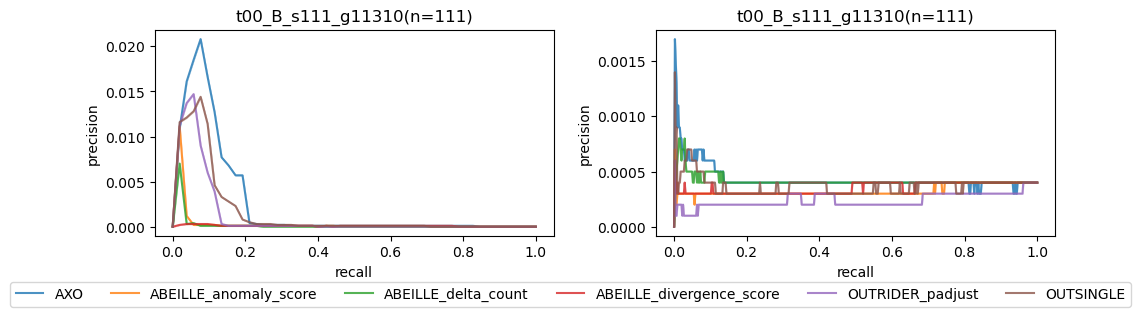

In [62]:
draw_methods = methods
plt.style.use('default')
fig, axes = plt.subplots(1, len(tissues),  figsize=(5*len(tissues), 3), sharey=False)
auprc = pd.DataFrame(index=tissues.index, columns=draw_methods)

ax_i = 0
for i, row in tissues.iterrows():
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    k = 'all'
    dict_curve[k],dict_auprc[k] = dict(),dict()
    if k == 'all':
        prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
        
    for m in draw_methods:
        print(m)
        file = f'{metric_output_path}/{prefix}_{m}_auprc{phase}{os.path.basename(outlierfile)}.pkl' # one tissue One method
        with open(file,'rb') as f:
            data_load = pickle.load(f)
            # print(tn, m)
        _t, _tn, _i, dict_auprc[k][m], dict_curve[k][m] = data_load[0], data_load[1], data_load[2], data_load[3], data_load[4]
        
    # print(t, tn, i,file)

    required_sets = 1
    draw = \
    pd.concat( [ 
        pd.concat( [ (dict_curve[k][m][j]) for j in range(required_sets)],
                axis=0, keys= range(required_sets)).reset_index(drop=True)
        for m in draw_methods ], axis=0, keys=draw_methods)\
    .rename(index={ 'f0.1L20':'AXO'}).reset_index()
    
    sns.lineplot(data=draw, x="recall", y="precision", hue="level_0", palette='tab10', alpha=0.8, ax= axes[ax_i])
    axes[ax_i].set_title(f'{prefix}(n={ns})')
    axes[ax_i].get_legend().remove()
    auprc.loc[ax_i,:] = [ dict_auprc['all'][m][0] for m in draw_methods ]
    ax_i = ax_i + 1
    
# 2. 用最后一根轴的“handles/labels”生成 Figure 级图例
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
        loc='center',           # 居中
        bbox_to_anchor=(0.5, 0),  # 放在底部（微调 0.02）
        ncol=len(labels),       # 横向排列
        frameon=True)
plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/ly111_auprc_curve.pdf',dpi=200, bbox_inches='tight')

In [ ]:
for i, row in tissues.iterrows():
    # --> level 1. one tissue
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    dict_res = dict()
    dict_auprc = dict()
    dict_curve = dict()
    
    prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
    
    # 读入任务
    task_config = pd.read_csv(f'{task_config_path}/{prefix}.config', sep='\t')
    samples = pd.read_csv(f'{samples_path}/{prefix}.txt', sep='\t',index_col='task')
    # all outlier
    # outliers_used = pd.read_csv(f'{samples_path}/{prefix}_outliers.txt', sep='\t',index_col=0)
    # valid split
    outliers_used = pd.read_csv(outlierfile.replace('.tsv', f'{phase}.tsv'), sep='\t',index_col=0)
    print(prefix, samples.shape, outliers_used.shape)

    if 'Sample' in outliers_used.columns:
        df_outlier = outliers_used
    else:
        outlier_sample_col = 'SAMPLE_ID'
        outlier_gene_col = 'Gene'
        df_outlier = outliers_used.rename(columns={outlier_sample_col:'Sample', outlier_gene_col:'Gene'})

    take = zip(df_outlier['Gene'],df_outlier['Sample'])

    for m in methods:
        # ==> level 3. (tissue, task, method)
        
        dict_res = dict()
        dict_auprc = dict()
        dict_curve = dict()
        
        for j,row in task_config.iterrows():
            # ==> level 4. (tissue, task, method)
            #----------- 调用函数auprc
            if m.startswith('ABEILLE'):
                method, score = m.split('_',1)
                print(method, score)

                df_pred = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                df_pred.index = [(s,g) for s,g in zip(df_pred['Sample'], df_pred['Transcript'])]
                            
            elif m.startswith('OUTRIDER'):
                method, score = m.split('_',1)
                print(method, score)
                df_pred = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                df_pred.index = [(s,g) for s,g in zip(df_pred['sampleID'], df_pred['geneID'])]

                        
            elif m == 'OUTSINGLE':
                print(m)
                df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)

            else: # my method
                print(m)
                df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)


t00_B_s111_g11310 (1, 111) (52, 36)
OUTRIDER padjust


KeyError: "None of [MultiIndex([( 'TMEM147',    'AS39082'),\n            ( 'TMEM147',    'AS40521'),\n            ( 'TMEM147',    'AS40688'),\n            (     'BTK', 'AS23161440'),\n            (   'BRAT1',    'AS30833'),\n            (   'BRAT1',    'AS30835'),\n            (    'EXT2',    'AS30696'),\n            ( 'TMEM147',    'AS40687'),\n            (   'MED25',    'AS81707'),\n            (   'TANC2',    'AS23098'),\n            (   'TANC2',    'AS26494'),\n            (     'PNP',    'AS72825'),\n            (   'SIN3A', 'AS23158309'),\n            (    'UBA5',    'AS60481'),\n            (  'STXBP1',    'AS71112'),\n            (  'PNPLA6',    'AS16343'),\n            ( 'SLC12A1',    'AS48433'),\n            (    'DYSF',    'AS52397'),\n            (    'UBA5',    'AS60480'),\n            (    'TSC1',    'AS64512'),\n            (   'SIN3A', 'AS23158310'),\n            (   'BRAT1',    'AS73212'),\n            ( 'SLC33A1',    'AS24813'),\n            (   'PIBF1',    'AS26875'),\n            (  'COL4A3',     'AS2864'),\n            (    'MCM9',    'AS24461'),\n            (    'DLG4', 'AS23157430'),\n            ( 'CWF19L1',    'AS20994'),\n            (   'RPL21',    'AS71932'),\n            (   'SNRPN',    'AS71575'),\n            (   'ADPRS',    'AS17036'),\n            (    'DYSF',    'AS20992'),\n            (    'TSC2',    'AS79750'),\n            ('RNASEH2C',    'AS59669'),\n            (    'NUS1',    'AS51367'),\n            (    'OFD1',    'AS62404'),\n            (   'BRAT1',    'AS30834'),\n            (  'COL6A2',    'AS63979'),\n            (    'WWOX',    'AS60159'),\n            (   'PIBF1',    'AS26873'),\n            (   'MED12',    'AS70305'),\n            (   'TRPM6',    'AS76056'),\n            (  'RECQL4',    'AS73209'),\n            (   'PIBF1',    'AS26874'),\n            (   'PEX10',    'AS80562'),\n            (   'CERT1',    'AS60586'),\n            (   'HUWE1',    'AS35814'),\n            (   'TRIM8',    'AS43107'),\n            (  'COL6A2',    'AS77213'),\n            (    'PKD1',    'AS80673'),\n            (  'KCTD17',    'AS26995'),\n            (   'IARS2',    'AS26996')],\n           )] are in the [index]"

In [ ]:
df_pred

In [ ]:
take = zip(df_outlier['Gene'],df_outlier['Sample'])
print( m, len(df_outlier), df_pred.stack().loc[take].mean(), df_pred.stack().mean() )

f0.1L20 444 -1.2752927927927928 -1.205633060115818


##### sdfjaiosdfasdf 

In [57]:
for name_prefix, auprc in auprc_data_for_boxplot.items():
    auprc_long = auprc.rename(columns={'f0.1L20':'AXO'}).stack().reset_index(name='AUPRC').rename(columns={'level_2':'Method'})
    
    g = sns.catplot( auprc_long, kind='box', y = 'Method', x='AUPRC', hue='Method', col='size', 
                orient='h', palette='tab10', sharex=False, height=3, aspect=2)
    g.fig.suptitle(name_prefix, fontsize=14, fontweight='bold')
    plt.tight_layout()
    # plt.savefig(f'{workdir}/result/figure/pmuscle_box_auprc_sizes13k_gene12k.pdf', dpi=200)
    
    # p-value
    auprc_all_sizes = auprc.astype(np.float32).copy()
    

NameError: name 'auprc_data_for_boxplot' is not defined

In [59]:
size

12000

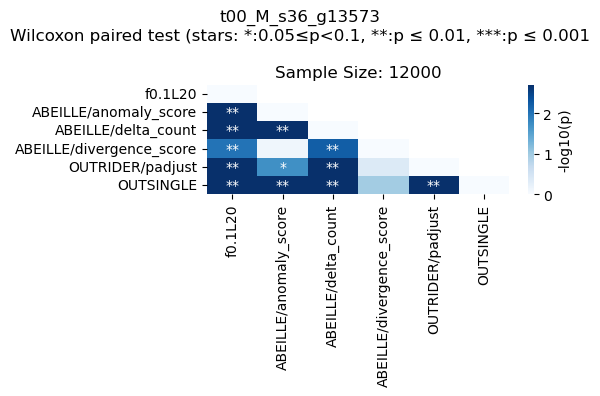

In [70]:
plt.style.use('default')

fig, axes = plt.subplots(1, 1, figsize=(6*1, 4), sharey=True, sharex=True)

auprc = auprc_all_sizes.query('size == @size').droplevel('size')
columns = auprc.columns.tolist()
results = pd.DataFrame(columns=['Method1', 'Method2', 'Statistic', 'p-value'])

for method1, method2 in itertools.combinations(columns, 2):
    x = auprc[method1].dropna()
    y = auprc[method2].dropna()
    
    # make they are same length
    min_len = min(len(x), len(y))
    x = x.iloc[:min_len]
    y = y.iloc[:min_len]
    
    # wilcoxon test
    alternative = 'two-sided'
    stat, p_value = wilcoxon(x, y, correction=True, alternative= alternative)

    new_row = pd.DataFrame({
        'Method1': [method1],
        'Method2': [method2],
        'Statistic': [stat],
        'p-value': [p_value]
    })
    
    results = pd.concat([results, new_row], ignore_index=True)

axo_results = results#.query('(Method1 not in @baselines) and (Method2 not in @baselines)')
# ---- 1. 对称矩阵化 ----
pivot = axo_results.pivot(index='Method1', columns='Method2', values='p-value')
pivot = pivot.combine_first(pivot.T)        # 补全下三角
np.fill_diagonal(pivot.values, 1)           # 对角=1

pivot = pivot.loc[columns, columns] # use the meothds order in auprc
# ---- 2. -log10 变换 ----
log_p = -np.log10(pivot)
log_p = log_p.replace([np.inf, -np.inf], np.nan)

# ---- 3. 三角掩码 ----
mask = np.triu(np.ones_like(log_p, dtype=bool), k=1)

def p2star(p):
    if pd.isna(p) or p > 0.05:
        return ''
    elif p <= 1e-4:
        return '****'
    elif p <= 1e-3:
        return '***'
    elif p <= 1e-2:
        return '**'
    else:
        return '*'

# 1. 星号对称矩阵（同索引）
star_mat = pivot.applymap(p2star)

# ---- 4. 画图 ----
# plt.figure(figsize=(10, 5))
sns.heatmap(log_p,
            mask=mask,
            cmap='Blues',
            annot=star_mat,
            fmt='',
            cbar_kws={'label': '-log10(p)'}, ax=axes)
# axes[sample_sizes.index(size)].set_xticklabels(axes[sample_sizes.index(size)].get_xticklabels(), rotation=90)
axes.set_title(f'Sample Size: {size}')

plt.suptitle(f'{name_prefix}\nWilcoxon paired test (stars: *:0.05≤p<0.1, **:p ≤ 0.01, ***:p ≤ 0.001')
plt.tight_layout() 
plt.savefig(f'{workdir}/result/figure/pmuscle_heatmap_auprc_wilcox_p_star.pdf',dpi=200)